# Evaluate Optimization



The optimization step is the most important on the spurious and intersection area ratio error. For that, we consider the variations of it in datasets of different size and the parameters $\lambda$.

In [1]:
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use("seaborn-paper")
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Roboto'

import sys
import os
module_path = os.path.abspath(os.path.join('../scripts'))
sys.path.append(module_path)

from metrics import compute_metrics
from morevis import MoReVis
from datasets import load_dataset

## Loading Data

In [2]:
df_wildtrack = load_dataset("wildtrack_use_case")
df_hurdat = load_dataset("hurdat_use_case")

wildtrack_timesteps = df_wildtrack.timestep.max() - df_wildtrack.timestep.min() + 1
hurdat_timesteps = int(df_hurdat.timestep.max() - df_hurdat.timestep.min() + 1)

wildtrack_objects = len(df_wildtrack.object.unique())
hurdat_objects = len(df_hurdat.object.unique())

print(f"WILDTRACK have {wildtrack_objects} unique objects and total of {wildtrack_timesteps} timesteps")
print(f"HURDAT have {hurdat_objects} unique objects and total of {hurdat_timesteps} timesteps")

WILDTRACK have 14 unique objects and total of 234 timesteps
HURDAT have 70 unique objects and total of 52 timesteps


## Running experiments

In [3]:
def evaluate_lamb_1_2(df, list_lamb1, list_lamb2):
    """
    For every combination of lamb1, lamb2 from the lists of list_lamb1, list_lamb2,
    will compute the MoReVis result and save the metrics.

    Inputs:
        df - DataFame with the data to be used in the MoReVis
        list_lamb1 - list of lamb1 values to be used
        list_lamb2 - list of lamb2 values to be used
    
    Outputs:
        spurious_intersection - array of spurious intersections for each combination of lamb1, lamb2
        intersection_area_ratio_mean - array of intersection area ratio mean for each combination of lamb1, lamb2
        computing_time - array of computing time for each combination of lamb1, lamb2
    """
    n, m = len(list_lamb1), len(list_lamb2)
    spurious_intersection = np.zeros((n, m))
    intersection_area_ratio = np.zeros((n, m))
    computing_time = np.zeros((n, m))

    for i, lamb1 in enumerate(list_lamb1):
        for j, lamb2 in tqdm(enumerate(list_lamb2)):
            optimization_params_copy = {}
            optimization_params_copy["lamb1"] = lamb1
            optimization_params_copy["lamb2"] = lamb2
            start = time()
            morevis_result, area_scaler = MoReVis(
                df, 
                optimization_params = optimization_params_copy,
                plot = False,
                return_area_scaler = True
            )

            end = time()
            morevis_result = compute_metrics(morevis_result, area_scaler)
            spurious_intersection[i, j] = morevis_result["spurious_intersections"]
            intersection_area_ratio[i, j] = morevis_result["intersection_area_ratio_mean"]
            computing_time[i, j] = end - start
    
    return spurious_intersection, intersection_area_ratio, computing_time

def evaluate_size(df, n_objects, n_trials = 10):
    """
    For every n in n_objects, will select n random objects n_trails time
    compute the MoReVis result and save the metrics.

    Inputs:
        df - DataFame with the data to be used in the MoReVis
        n_objects - list of n values to be used
        n_trials - number of trials to be used for each n
    
    Outputs:
        results - DataFrame with metrics
    """
    results = {
        "n_objects": [],
        "time": [],
        "spurious_intersections": [], 
        "intersection_area_ratio_mean": [],
        }
               
    for n1 in tqdm(n_objects):
        for _ in range(n_trials):
            selected_objects = np.random.choice(df.object.unique(), n1, replace = False)
            df_filtered = df[df.object.isin(selected_objects)]
            start = time()
            morevis_result, area_scaler = MoReVis(
                df_filtered,
                plot = False,
                return_area_scaler = True
            )
            
            end = time()
            morevis_result = compute_metrics(morevis_result, area_scaler)
            results["n_objects"].append(n1)
            results["time"].append(end - start)
            results["spurious_intersections"].append(morevis_result["spurious_intersections"])
            results["intersection_area_ratio_mean"].append(morevis_result["intersection_area_ratio_mean"])

    results = pd.DataFrame(results)
    return results

We could compare different combinations of the values $(\lambda_1, \lambda_2)$, however, based on the formulation of the minimization problem, it only matters the ration $\frac{\lambda_2}{\lambda_1}$, so we will fix $\lambda_1=1$ and test $\lambda_2 \in \{0.001, 0.01, 0.1, 1, 10, 100, 1000 \}$.

In [4]:
list_lamb1 = [1]
list_lamb2 = [0.001, 0.01, 0.1, 1, 10, 100, 1000] 

In [7]:
# long running time
spurious_intersection_wildtrack, intersection_area_ratio_wildtrack, computing_time_wildtrack = evaluate_lamb_1_2(
    df_wildtrack, 
    list_lamb1, list_lamb2
)
np.save("metrics-results/spurious_intersection_wildtrack", spurious_intersection_wildtrack)
np.save("metrics-results/intersection_area_ratio_wildtrack", intersection_area_ratio_wildtrack)
np.save("metrics-results/computing_time_wildtrack", computing_time_wildtrack)

spurious_intersection_hurdat, intersection_area_ratio_hurdat, computing_time_hurdat = evaluate_lamb_1_2(
    df_hurdat, 
    list_lamb1, list_lamb2
)
np.save("metrics-results/spurious_intersection_hurdat", spurious_intersection_hurdat)
np.save("metrics-results/intersection_area_ratio_hurdat", intersection_area_ratio_hurdat)
np.save("metrics-results/computing_time_hurdat", computing_time_hurdat)

7it [01:19, 11.31s/it]
7it [01:29, 12.78s/it]


To evaluate the impact of the size of the dataset in the MoReVis result, we will select random subsets of the objects and compute the MoReVis with it. The number of objects selected from WILDTRACK will be $\{5, 6, 7, 8, 9, 10, 11, 12, 13 14\}$ and with HURDAT it will be $\{25, 30, 35, 40, 45, 50, 55, 60, 65, 70\}. WILDTRACK have a total of $14$ objects and HURDAT have $70$, so at the end we will test with the complete dataset.

In [5]:
n_objects_wildtrack = [i+5 for i in range(10)]
n_objects_hurdat = [i*5+25 for i in range(10)]

In [6]:
# long running time

wildtrack_number_objects_results = evaluate_size(df_wildtrack, n_objects_wildtrack)
wildtrack_number_objects_results.to_csv("metrics-results/wildtrack_number_objects_results.csv", index = False)


hurdat_number_objects_results = evaluate_size(df_hurdat, n_objects_hurdat)
hurdat_number_objects_results.to_csv("metrics-results/hurdat_number_objects_results.csv", index = False)

100%|██████████| 10/10 [11:57<00:00, 71.72s/it] 


## Analysing Results


We will now plot the results of the experiments.

In [7]:
# Loading experiments results
spurious_intersection_wildtrack = np.load("metrics-results/spurious_intersection_wildtrack.npy")
intersection_area_ratio_wildtrack = np.load("metrics-results/intersection_area_ratio_wildtrack.npy")
computing_time_wildtrack = np.load("metrics-results/computing_time_wildtrack.npy") / wildtrack_timesteps 

spurious_intersection_hurdat = np.load("metrics-results/spurious_intersection_hurdat.npy")
intersection_area_ratio_hurdat = np.load("metrics-results/intersection_area_ratio_hurdat.npy")
computing_time_hurdat = np.load("metrics-results/computing_time_hurdat.npy") / hurdat_timesteps

wildtrack_number_objects_results = pd.read_csv("metrics-results/wildtrack_number_objects_results.csv")
wildtrack_number_objects_results["time"] = wildtrack_number_objects_results["time"] / wildtrack_timesteps
wildtrack_number_objects_results = wildtrack_number_objects_results.groupby("n_objects")
wildtrack_n_objects_fraction = wildtrack_number_objects_results.sum().index.values /  wildtrack_number_objects_results.sum().index.values.max()

hurdat_number_objects_results = pd.read_csv("metrics-results/hurdat_number_objects_results.csv")
hurdat_number_objects_results["time"] = hurdat_number_objects_results["time"] / hurdat_timesteps
hurdat_number_objects_results = hurdat_number_objects_results.groupby("n_objects")
hurdat_n_objects_fraction = hurdat_number_objects_results.sum().index.values /  hurdat_number_objects_results.sum().index.values.max()


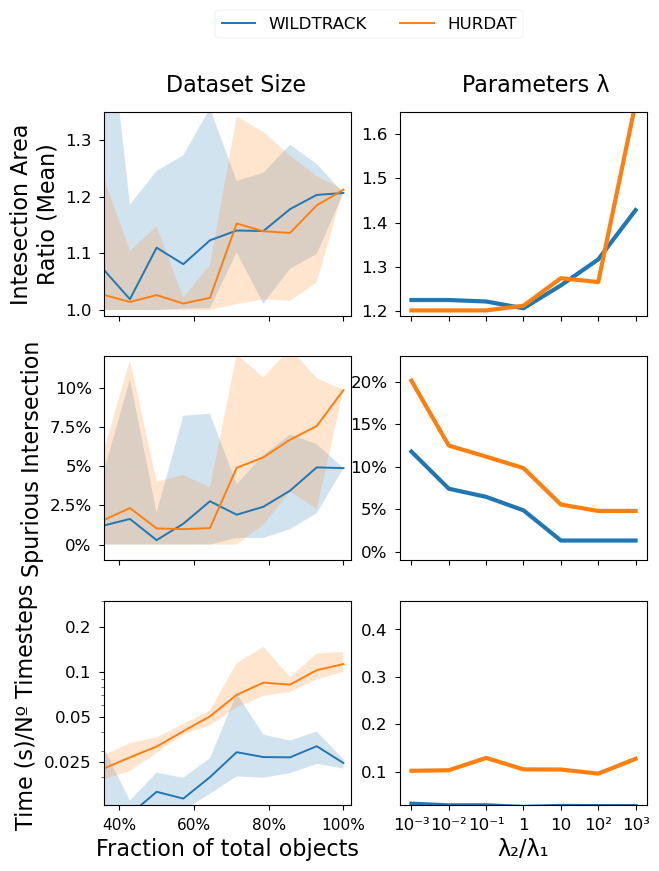

In [8]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (7, 9))

title = ["Intesection Area\nRatio (Mean)", "Spurious Intersection", "Time (s)/Nº Timesteps "]
metric_results = [
    (intersection_area_ratio_wildtrack, intersection_area_ratio_hurdat),
    (spurious_intersection_wildtrack, spurious_intersection_hurdat),
    (computing_time_wildtrack, computing_time_hurdat)
]

# varying dataset size
for i, metric in enumerate(["intersection_area_ratio_mean", "spurious_intersections", "time"]):
    ax[i][0].fill_between(
        wildtrack_n_objects_fraction,
        wildtrack_number_objects_results.min().reset_index()[metric],
        wildtrack_number_objects_results.max().reset_index()[metric],
        alpha = 0.2,
    )

    ax[i][0].plot(
        wildtrack_n_objects_fraction,
        wildtrack_number_objects_results.mean().reset_index()[metric],
        label = "WILDTRACK"
        )

    ax[i][0].fill_between(
        hurdat_n_objects_fraction,
        hurdat_number_objects_results.min().reset_index()[metric],
        hurdat_number_objects_results.max().reset_index()[metric],
        alpha = 0.2,
    )

    ax[i][0].plot(
        hurdat_n_objects_fraction,
        hurdat_number_objects_results.mean().reset_index()[metric],
        label = "HURDAT"
    )

    ax[i][0].set_ylabel(title[i], fontsize = 16)
    ax[i][0].set_xticks([0.4,  0.6, 0.8, 1.])
    ax[i][0].set_xticklabels([])
    ax[i][0].set_xlim([0.36, 1.02])

ax[2][0].set_xlabel("Fraction of total objects", fontsize = 16) 
ax[2][0].set_xticklabels(["40%", "60%",  "80%","100%"], fontsize = 11)


# varying lambda
for i, (metric_wildtrack, metric_hurdat) in enumerate(metric_results):
    ax[i][1].plot(list(range(len(list_lamb2))), metric_wildtrack[0], label = f"WILDTRACK", lw = 3)
    ax[i][1].plot(list(range(len(list_lamb2))), metric_hurdat[0], label = f"HURDAT", lw = 3)
    ax[i][1].set_ylabel(title[i], fontsize = 16)
    ax[i][1].set_xticks(list(range(len(list_lamb2))))
    ax[i][1].set_xticklabels("")

ax[2][1].set_xlabel("λ₂/λ₁", fontsize = 16, font = "Dejavu Sans")
ax[2][1].set_xticklabels(["10⁻³", "10⁻²", "10⁻¹", "1", "10", "10²", "10³"], fontsize = 12, font = "Dejavu Sans")

ax[0][0].set_ylim(0.99, 1.35)
ax[0][0].set_yticks([1., 1.1, 1.2, 1.3])
ax[0][0].set_yticklabels(["1.0", "1.1", "1.2", "1.3"], fontsize = 12)
ax[0][1].set_ylim(1.19, 1.65)
ax[0][1].set_yticks([1.2, 1.3, 1.4, 1.5, 1.6])
ax[0][1].set_yticklabels(["1.2", "1.3", "1.4", "1.5", "1.6"], fontsize = 12)

ax[1][0].set_yticks([0., 0.025, 0.05, 0.075, 0.1])
ax[1][0].set_yticklabels(["0%", "2.5%", "5%", "7.5%", "10%",], fontsize = 12)
ax[1][0].set_ylim(-0.01, 0.12)
ax[1][1].set_ylim(-0.01, 0.23)
ax[1][1].set_yticks([0., 0.05, 0.1, 0.15, 0.2])
ax[1][1].set_yticklabels(["0%", "5%", "10%", "15%", "20%"], fontsize = 12)


ax[2][0].set_yscale("log")
ax[2][0].set_ylim([0.013, 0.3])
ax[2][0].set_yticks([0.025, 0.05, 0.1, 0.2])
ax[2][0].set_yticklabels([0.025, 0.05, 0.1, 0.2], fontsize = 12)
ax[2][1].set_ylim([0.03, 0.46])
ax[2][1].set_yticks([0.1, 0.2, 0.3, 0.4])
ax[2][1].set_yticklabels([0.1, 0.2, 0.3, 0.4], fontsize = 12)

for i in range(3):
    ax[i][1].set_ylabel("")

# title and legend
ax[0][0].annotate("Dataset Size", xy = (0.25, 1.1), xycoords = "axes fraction", fontsize = 16)
ax[0][1].annotate("Parameters λ", xy = (0.25, 1.1), xycoords = "axes fraction", fontsize = 16)
ax[0][0].legend(bbox_to_anchor = (0.45, 1.5), loc = 2, borderaxespad = 0., fontsize = 12, ncol = 2)

#plt.savefig("plots/optimization_metrics.svg", format = "svg", dpi = fig.dpi)
plt.show()